In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [29]:
# Bird object with attributes pos (2-D vector), vel (2-D vector), [axis (?)]

class boid:
    def __init__(self, pos_x, pos_y, vel_x, vel_y):
        self.pos = np.array([pos_x, pos_y])
        self.vel = np.array([vel_x, vel_y])
        
    def move(self, goal, mu, dt):
        self.vel = (1 - mu) * self.vel + mu * goal
        self.vel = self.vel / np.linalg.norm(self.vel)
        self.pos += dt * self.vel

In [30]:
# Magnitude function

def mag(vec):
    magnitude = np.linalg.norm(vec)
    return magnitude

In [31]:
# Angle_diff (find angle between two vectors in radians) function

def angle_diff(vec1, vec2):
    angle = np.arccos(np.dot(vec1, vec2)/(mag(vec1)*mag(vec2)))
    return angle

In [32]:
# Get_neighbors function finds other boids in the field of view

# Takes: "self" = self boid, "others" = list of other boids, "radius" = radius of vision, "angle" = field of view
# Returns: a list of the boids in the field of view

def get_neighbors(self, others, radius, angle):
    boids = []
    for other in others:
        
        # if other boid is itself, skip it
        if other is self:
            continue

        offset = other.pos - self.pos

        # if not in range, skip it
        if mag(offset) > radius:
            continue

        # if not within viewing angle, skip it
        if angle_diff(self.vel, offset) > angle:
            continue

        # otherwise add it to the list
        boids.append(other)

    return boids

In [33]:
# Get_neighbors tester

me = boid(0, 0, 1, 0) # self boid with direction on positive x-axis
b2 = boid(1, 0, 0, 0) # other boid position (1, 0) should be in view
b3 = boid(0, 1, 0, 0) # other boid position (0, 1) should be out of view (angle)
b4 = boid(3, 0, 0, 0) # other boid position (0, 1) should be out of view (distance)
b5 = boid(1, -0.2, 0, 0) # other boid position (1, -0.2) should be in view
o = [b2, b3, b4, b5]

radius = 2
angle = np.pi/4

neighbors = get_neighbors(me, o, radius, angle)
for i, item in enumerate(neighbors):
    print(neighbors[i].pos)
    
# Should print (1, 0) and (1, -0.2) representing positions of b1 and b5, the two boids in the field of view

[1 0]
[ 1.  -0.2]


In [34]:
# Center function returns a normalized vector pointing at the origin (our fixed center of mass)

def center(self):
    center_point = np.array(-self.pos) / mag(self.pos)
    return center_point

In [35]:
# Center tester

b4 = boid(3, 0, 1, 1) # boid at position (3, 0) needs to get normalized to mag = 1

center(b4)

# Should print (1, 0)

array([-1.,  0.])

In [36]:
# Avoid function returns a normalized vector pointing directly away from the nearest visible boid

def avoid(self, others, radius, angle):
    
    # Find all visible_boids using get_neighbors
    visible_boids = get_neighbors(self, others, radius, angle)
    
    # If no visible_boids, return an empty vector
    if not visible_boids:
        return np.array([0, 0])
    
    # Find the nearest_boid out of the visible_boids
    nearest_boid = None
    min_distance = float('inf')  # Set initial min_distance to infinity

    for other_boid in visible_boids:
        distance = mag(other_boid.pos - self.pos)

        if distance < min_distance:
            nearest_boid = other_boid
            min_distance = distance
            
    # If no nearest_boid, return an empty vector
    if not nearest_boid:
        return np.array([0, 0])
    
    # Return a normalized vector pointing directly away from nearest_boid
    offset = nearest_boid.pos - self.pos
    
    if mag(offset) == 0:
        print("Warning: Avoidance offset magnitude is zero.")
        run_away = np.array([0, 0])
    else:
        run_away = np.array(-offset) / mag(offset)
    
    return run_away

In [37]:
# Avoid tester

me = boid(0, 0, 0, 0)
c1 = boid(2, 1, 0, 0)
c2 = boid(2, 2, 0, 0)
c3 = boid(1, 0, 0, 0) # Nearest boid
c4 = boid(5, 2, 0, 0)
c = [c1, c2, c3, c4]

print(avoid(me, c, 10, 2*np.pi)) # Field of view encompasses all boids in c

# Should print (-1, 0) as that is the vector pointing directly away from the nearest boid, c3

print(avoid(me, c, 0.2, 2*np.pi)) # Tiny field of view, no boids in vision

# Should print (0, 0) as no boids are visible

[-1.  0.]
[0 0]


/var/folders/dq/17k9n8_50ln7kw09jmqd7czm0000gn/T/ipykernel_71272/1352719432.py:4: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.dot(vec1, vec2)/(mag(vec1)*mag(vec2)))


In [38]:
# Copy function returns a normalized vector that matches the velocity of visible boids

def copy(self, others, radius, angle):
    
    # Find all visible_boids using get_neighbors
    visible_boids = get_neighbors(self, others, radius, angle)
    
    # Check if no visible_boids
    if not visible_boids:
        print("Warning: No visible boids found.")
    
    # Add together all velocities of visible_boids to represent copying directions of all visible_boids
    velocities = []
    for i, item in enumerate(visible_boids):
        velocity = visible_boids[i].vel
        velocities.append(velocity)
        
    # Check if all velocities = 0
    if all(np.all(vel == 0) for vel in velocities):
        print("Warning: All visible boids have zero velocity.")
            
    # Return a normalized vector of aligned velocities
    if mag(np.sum(velocities, axis=0)) == 0:
        print("Warning: Copy velocity vector magnitude is zero.")
        follow_the_flock = np.array([0, 0])
    else:
        follow_the_flock = np.sum(velocities, axis=0) / mag(np.sum(velocities, axis=0))
    
    return follow_the_flock

In [39]:
# Copy tester

me = boid(0, 0, 0, 0)
c1 = boid(2, 1, 1, 1)
c2 = boid(2, 2, -1, 0)
c = [c1, c2]

copy(me, c, 10, 2*np.pi) # Field of view encompasses all boids in c

# Should print (0, 1) as that is the copy vector

/var/folders/dq/17k9n8_50ln7kw09jmqd7czm0000gn/T/ipykernel_71272/1352719432.py:4: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.dot(vec1, vec2)/(mag(vec1)*mag(vec2)))


array([0., 1.])

In [40]:
# Set_goal computes the weighted sum of the goals and sets the overall goal

# Takes: self, others, radius, angle
# Returns: normalized weighted goal vector

def set_goal(self, others, radius, angle):
    
    goal = (w_avoid*avoid(self, others, radius, angle) + w_center*center(self)
            + w_copy*copy(self, others, radius, angle))
    
    if mag(goal) == 0:
        print("Warning: Goal vector magnitude is zero.")
        goal_norm = np.array([0, 0])
    else:
        goal_norm = goal / mag(goal)
    
    return [goal_norm, w_avoid*avoid(self, others, radius, angle), w_center*center(self),
                       w_copy*copy(self, others, radius, angle)]

In [41]:
# move updates the velocity, position and attitude of the boid:
# The parameter mu determines how quickly the birds can change speed and direction
# The time step, dt determines how far the boids move.
#def move(self, goal, mu=0.1):
    #self.vel = (1-mu) * self.vel + mu * goal
    #self.vel = self.vel / mag(self.vel)

    #self.pos += dt * self.vel

### Simulation

In [45]:
num_boids = 100  # Number of boids
num_steps = 6  # Number of time steps in the simulation
mu = 0.1  # Speed/direction change factor
dt = 1  # Time step size

radius = 5
angle = np.pi

w_avoid = 1/3
w_center = 1/3
w_copy = 1/3

#print('Wsum', w_avoid + w_center + w_copy)

In [46]:
# Initialize boids with random positions and 0 velocity
np.random.seed(1)
boids = [boid(pos_x, pos_y, vel_x, vel_y) 
         for pos_x, pos_y, vel_x, vel_y in zip(np.random.uniform(-5, 5, num_boids), 
                                               np.random.uniform(-5, 5, num_boids),
                                               np.random.uniform(-0.2, 0.2, num_boids), 
                                               np.random.uniform(-0.2, 0.2, num_boids))]

# Check initial positions of boids
#for i, b in enumerate(boids):
    #print(f"Boid {i}: Position = {b.pos}, Velocity = {b.vel}")

<IPython.core.display.Javascript object>


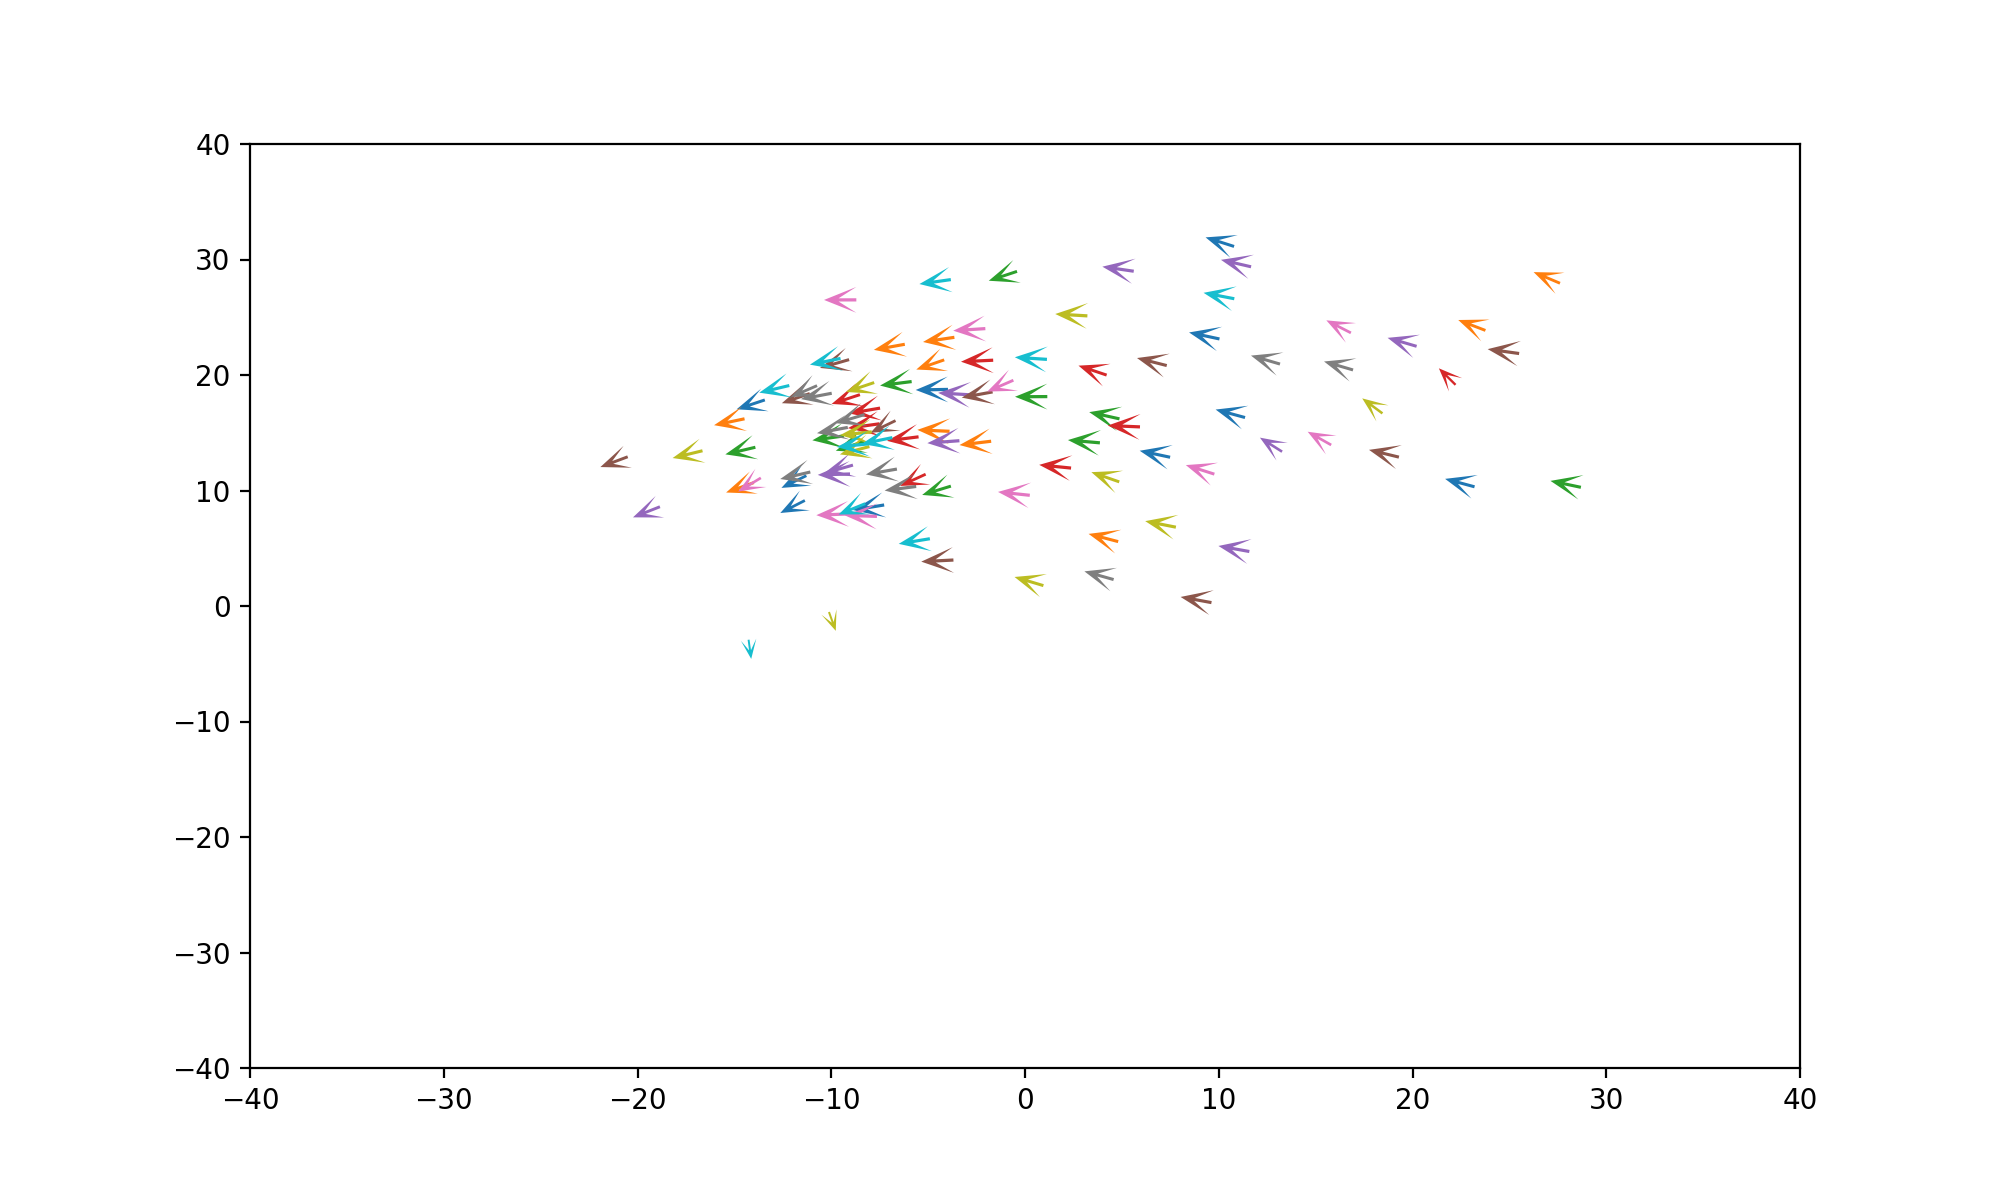

In [47]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
colors = plt.cm.tab10(np.linspace(0, 1, num_boids))

# Initialize plot elements for each boid
lines = [ax.quiver(b.pos[0], b.pos[1], b.vel[0], b.vel[1], color=colors[i], scale=0.6, scale_units='xy', angles='xy', headwidth=8, headlength=10) for i, b in enumerate(boids)]

# Initialize list to store temperature values
temperatures = []

def update(frame):
    for i, b in enumerate(boids):
        # Update goal
        goal_list = set_goal(b, boids, radius, angle)
        goal = goal_list[0]

        # Update position and velocity
        b.move(goal, mu, dt)

    # Update plot elements
    for i, line in enumerate(lines):
        line.set_offsets(boids[i].pos)
        line.set_UVC(boids[i].vel[0], boids[i].vel[1])
        
     # Calculate the average speed squared
    average_speed_squared = np.mean([mag(b.vel) for b in boids])

    # Define the temperature as proportional to the average speed squared
    temperature = average_speed_squared
    
    # Append the temperature to the list
    temperatures.append(temperature)

    return lines

ani = FuncAnimation(fig, update, frames=num_steps, blit=True, interval=50, repeat_delay=100)
plt.show()

In [49]:
print(temperatures)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


<IPython.core.display.Javascript object>


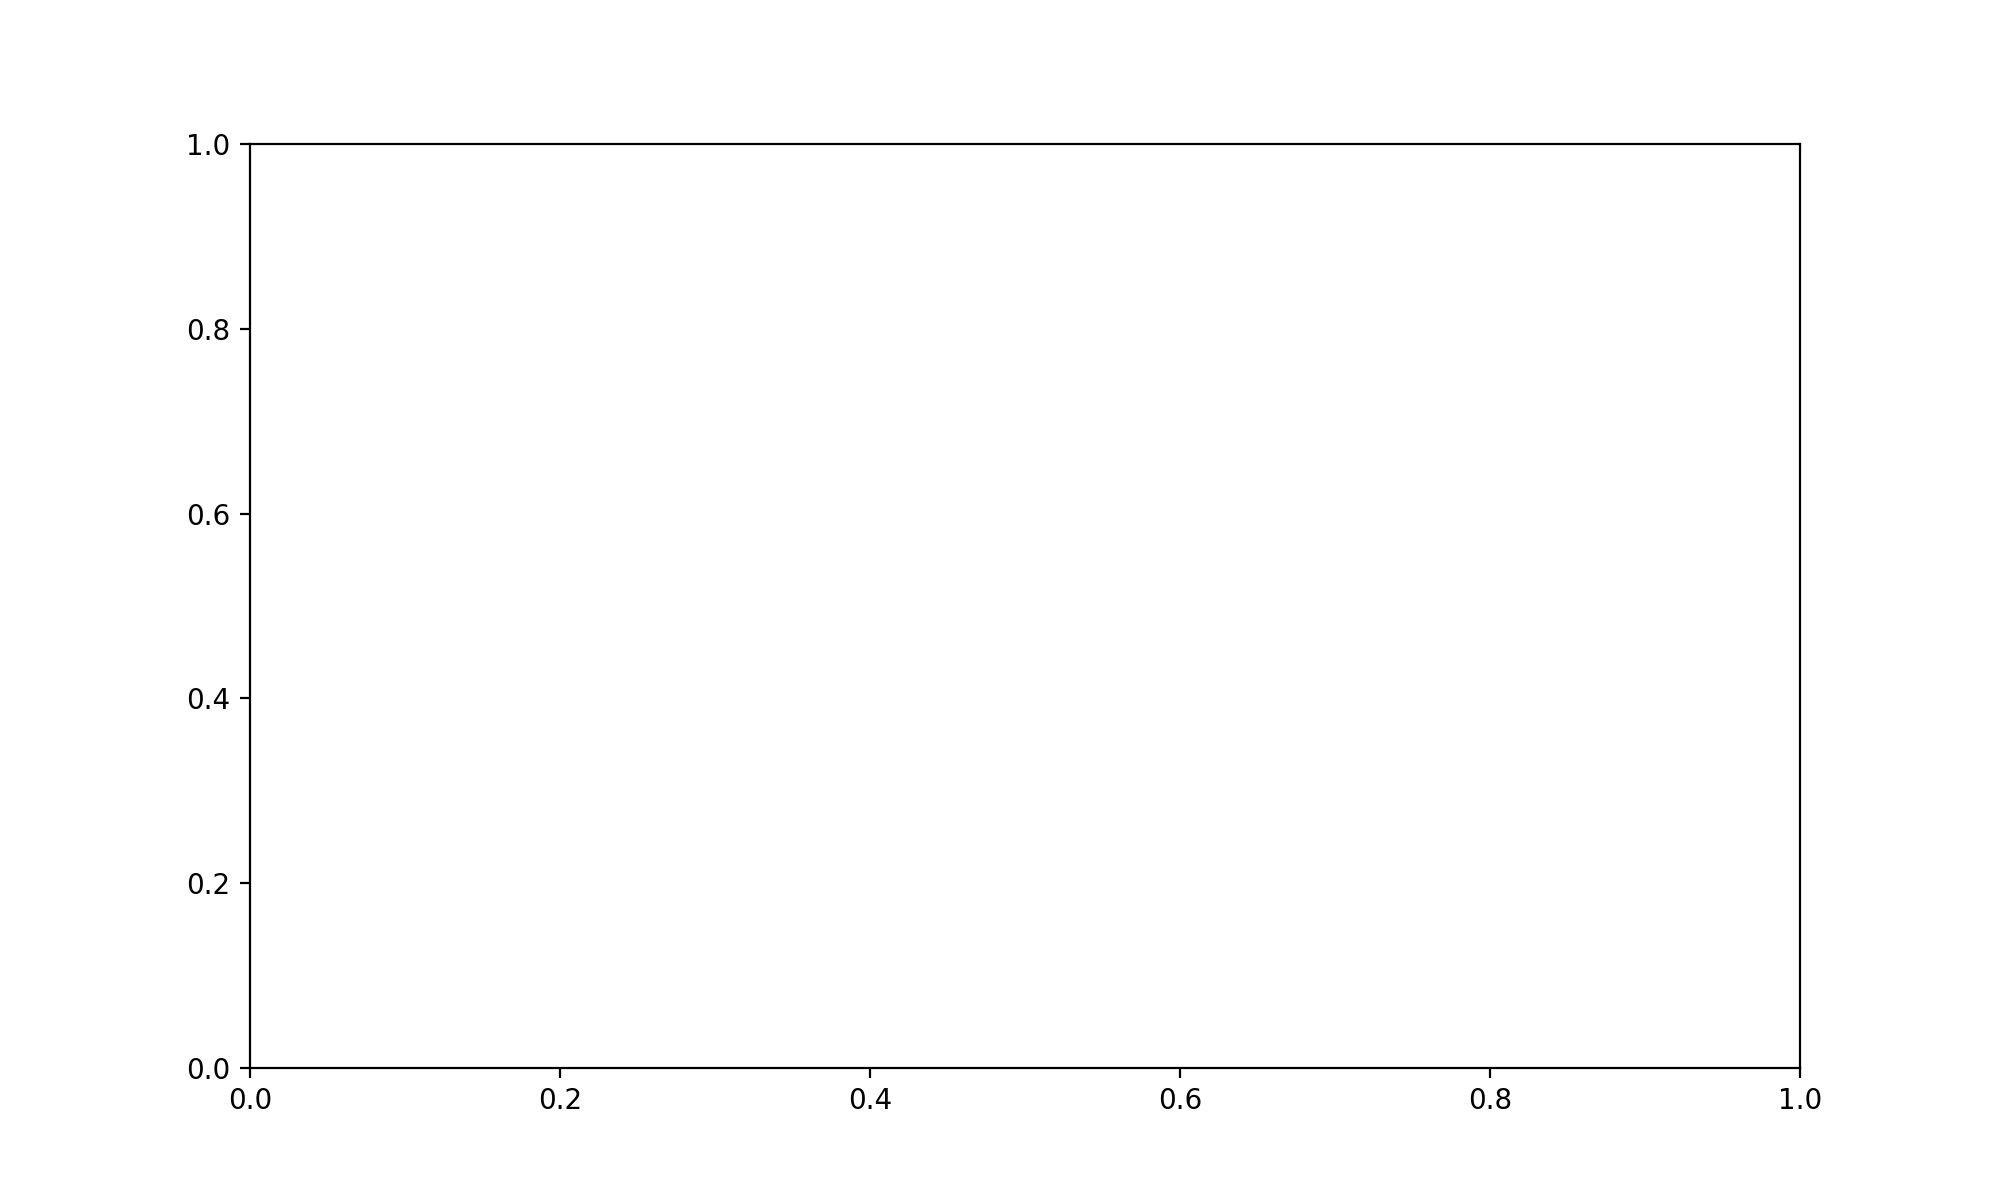

ValueError: x and y must have same first dimension, but have shapes (6,) and (28,)

In [202]:
# Plot the temperature vs. time
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(range(num_steps), temperatures, label='Temperature')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Temperature')
ax2.legend()
plt.show()